To run this notebook, you will have to use LEAP-Pangeo hub!

<a href="https://leap.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fm2lines%2Fdata-gallery&urlpath=lab%2Ftree%2Fdata-gallery%2Fnotebooks%2FOM4_SE_animation.ipynb&branch=main"><img src="https://custom-icon-badges.demolab.com/badge/LEAP-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:30px;"></a>

# OM4 Animation

In this notebook, we will visualize the OM4 data using the `xarray` and `matplotlib` libraries and create an animation of the Surface Kinetic Energy over time. We will explore visualizations in both global and regional scales. 

Credits: https://github.com/Pperezhogin/MOM6/blob/Zanna-Bolton-2020/experiments/ZB20-Results/14-Global-animation.ipynb

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import (
    remesh,
    gaussian_remesh,
    select_LatLon,
    Lk_error,
    x_coord,
    y_coord,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os

%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
import matplotlib as mpl
import cartopy.crs as ccrs

hvplot.output(widget_location="bottom")

In [ ]:
path = "gs://leap-persistent/jbusecke/OM4_m2lines/daily_combined.zarr"
ds = xr.open_dataset(path, engine="zarr", chunks={})
ds

<xarray.Dataset>
Dimensions:       (yq: 1081, xq: 1441, yh: 1080, xh: 1440, experiment: 2,
                   time: 1827, nv: 2)
Coordinates: (12/34)
    Coriolis      (yq, xq) float32 dask.array<chunksize=(271, 361), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(270, 360), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(271, 361), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(270, 361), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(271, 360), meta=np.ndarray>
    basin         (yh, xh) int32 dask.array<chunksize=(270, 360), meta=np.ndarray>
    ...            ...
    wet_u         (yh, xq) float32 dask.array<chunksize=(270, 361), meta=np.ndarray>
    wet_v         (yq, xh) float32 dask.array<chunksize=(271, 360), meta=np.ndarray>
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables:
    average_DT    (experiment, time) timedelta64[ns] dask.array<chunksize=(2, 1827), meta=np.ndarray>
    average_T1    (experiment, time) datetime64[ns] dask.array<chunksize=(2, 1827), meta=np.ndarray>
    average_T2    (experiment, time) datetime64[ns] dask.array<chunksize=(2, 1827), meta=np.ndarray>
    ssu           (experiment, time, yh, xq) float32 dask.array<chunksize=(1, 20, 1080, 1441), meta=np.ndarray>
    ssv           (experiment, time, yq, xh) float32 dask.array<chunksize=(1, 20, 1081, 1440), meta=np.ndarray>
    time_bnds     (experiment, time, nv) object dask.array<chunksize=(2, 1827, 2), meta=np.ndarray>
    tos           (experiment, time, yh, xh) float32 dask.array<chunksize=(1, 20, 1080, 1440), meta=np.ndarray>
    zos           (experiment, time, yh, xh) float32 dask.array<chunksize=(1, 20, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 20080101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_bugfixes_JRA55do1.5_cycle1

In [ ]:
ZBu = ds["ssu"].sel(experiment="ZB2020")
ZBv = ds["ssv"].sel(experiment="ZB2020")
ZBT = ds["tos"].sel(experiment="ZB2020")

In [ ]:
loresu = ds["ssu"].sel(experiment="unparameterized")
loresv = ds["ssv"].sel(experiment="unparameterized")
loresT = ds["tos"].sel(experiment="unparameterized")

In [ ]:
def KE(u, v, T):
    return 0.5 * (remesh(u**2, T) + remesh(v**2, T))

In [ ]:
ZBke = KE(ZBu, ZBv, ZBT)
loreske = KE(loresu, loresv, ZBT)

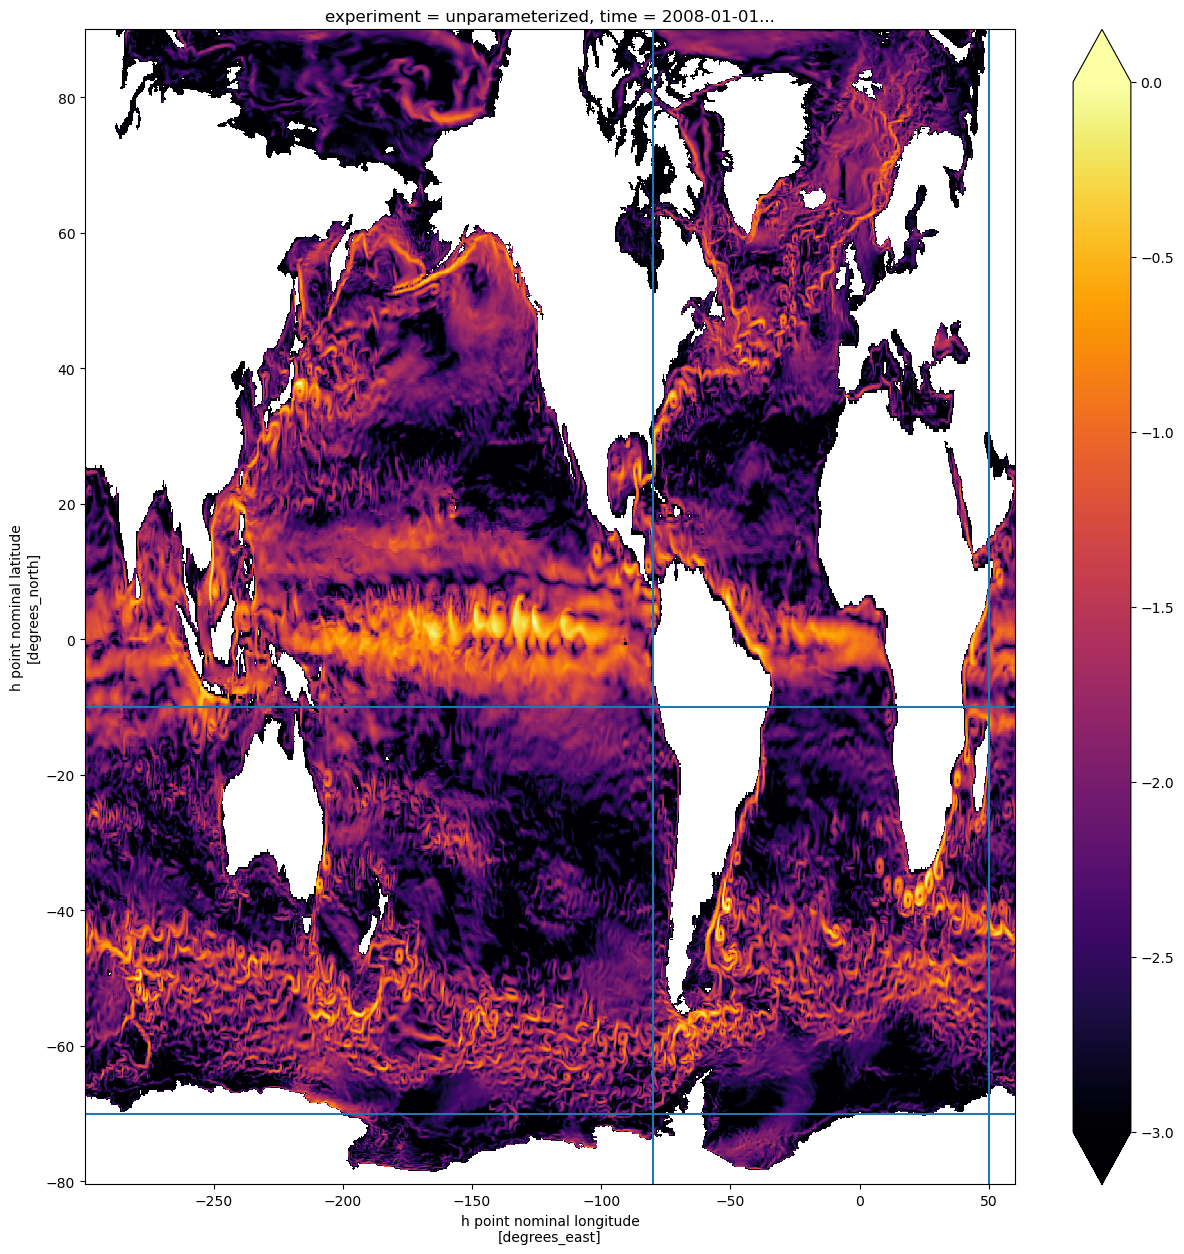

In [ ]:
plt.figure(figsize=(15, 15))
np.log10(loreske.isel(time=0)).plot(cmap="inferno", vmin=-3, vmax=0)
plt.axvline(x=-80)
plt.axvline(x=50)
plt.axhline(y=-70)
plt.axhline(y=-10)

# Global plotter

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import cartopy.crs as ccrs
import matplotlib as mpl


default_rcParams({"figure.subplot.hspace": 0.05, "font.size": 30})


def update_frame(i, plot_func, fig):
    # Clear the current figure to prepare for the next frame's plot.
    plt.clf()

    plot_func(i, fig)


def create_gif(plot_func, idx, filename="my-animation.gif", dpi=200, FPS=18, loop=0):
    fig = plt.figure(figsize=(10, 20))
    ani = FuncAnimation(
        fig,
        update_frame,
        frames=idx,
        fargs=(plot_func, fig),
        repeat=bool(loop),
        blit=False,
    )

    writer = PillowWriter(fps=FPS, metadata=dict(artist="Me"))
    ani.save(filename, writer=writer)
    plt.close(fig)


def plot_global(i=0, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(7, 13))
    time_idx = i * 5
    time_str = loreske.time.isel(time=time_idx).item().strftime("%Y-%m-%d")

    ax1 = plt.subplot(211, projection=ccrs.Orthographic(central_longitude=i))
    ax1.coastlines(resolution="110m")
    ax1.gridlines()
    im = loreske.isel(time=time_idx).plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
        cmap="inferno",
        add_colorbar=False,
    )
    ax1.set_title("$1/4^o$", fontsize=30)

    ax2 = plt.subplot(212, projection=ccrs.Orthographic(central_longitude=i))
    ax2.coastlines(resolution="110m")
    ax2.gridlines()
    im = ZBke.isel(time=time_idx).plot(
        ax=ax2,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
        cmap="inferno",
        add_colorbar=False,
    )
    ax2.set_title("$1/4^o$, ZB2020", fontsize=30)
    cb = plt.colorbar(im, pad=0.02, ax=[ax1, ax2], extend="both", aspect=50, shrink=0.9)
    cb.set_label(label="Surface KE, $\mathrm{m}^2/\mathrm{s}^2$", fontsize=30)
    plt.suptitle(time_str)

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.


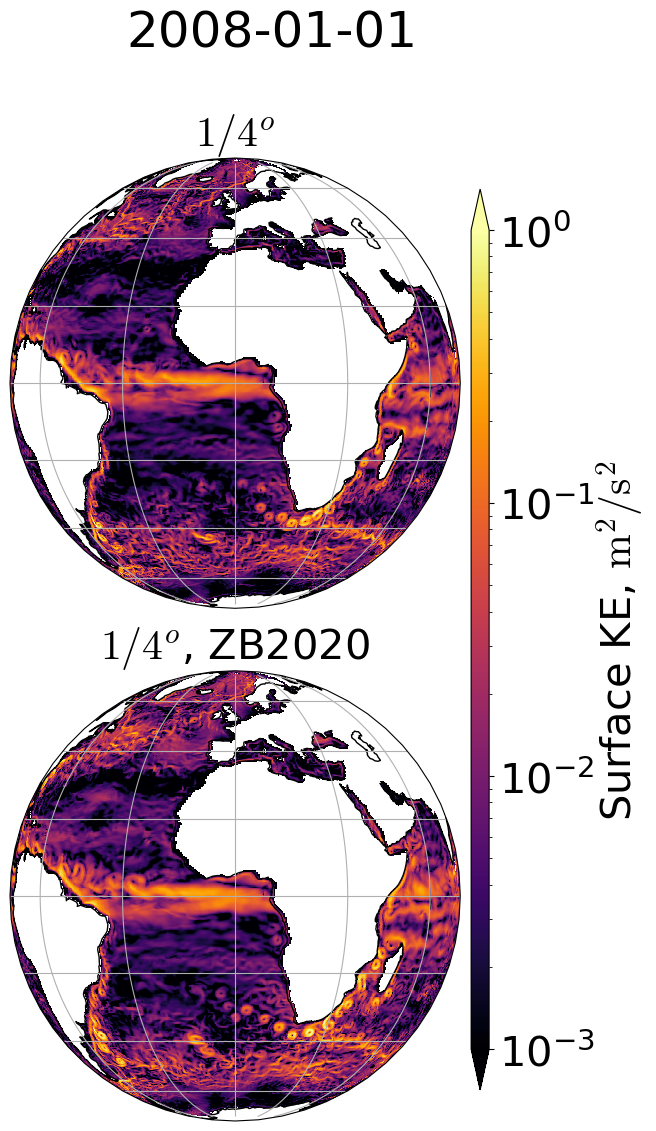

In [ ]:
plot_global()

Here, we show the animation of the Surface Kinetic Energy in intervals of 5 days shifting the longitude by 5 degrees each step. 


In [ ]:
%%time
create_gif(
    plot_global,
    range(0, 360, 5),
    filename="./global-ZB2020.gif",
    dpi=200,
    FPS=18,
    loop=0,
)

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not

CPU times: user 14min 38s, sys: 5min 29s, total: 20min 8s
Wall time: 14min 57s


# Regional plotter

In [ ]:
default_rcParams({"figure.subplot.hspace": 0.05, "font.size": 30})


def plot_regions(i=0, lat=slice(15, 70), lon=slice(-100, 0), fig=None):
    if fig is None:
        fig = plt.figure(figsize=(7, 13))
    time_idx = i
    time_str = loreske.time.isel(time=time_idx).item().strftime("%Y-%m-%d")

    ax1 = plt.subplot(
        211,
        projection=ccrs.Orthographic(
            central_latitude=(lat.start + lat.stop) / 2,
            central_longitude=(lon.start + lon.stop) / 2,
        ),
    )
    ax1.coastlines(resolution="110m")
    ax1.gridlines()
    im = (
        loreske.isel(time=time_idx)
        .sel(xh=lon, yh=lat)
        .plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
            cmap="inferno",
            add_colorbar=False,
        )
    )
    ax1.set_title("$1/4^o$", fontsize=30)

    ax2 = plt.subplot(
        212,
        projection=ccrs.Orthographic(
            central_latitude=(lat.start + lat.stop) / 2,
            central_longitude=(lon.start + lon.stop) / 2,
        ),
    )
    # ax2.coastlines(resolution='110m')
    ax2.gridlines()
    im = (
        ZBke.isel(time=time_idx)
        .sel(xh=lon, yh=lat)
        .plot(
            ax=ax2,
            transform=ccrs.PlateCarree(),
            norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0),
            cmap="inferno",
            add_colorbar=False,
        )
    )
    ax2.set_title("$1/4^o$, ZB2020", fontsize=30)
    cb = plt.colorbar(im, pad=0.02, ax=[ax1, ax2], extend="both", aspect=50, shrink=0.9)
    cb.set_label(label="Surface KE, $\mathrm{m}^2/\mathrm{s}^2$", fontsize=30)
    plt.suptitle(time_str)

## Plotting the Surface Kinetic Energy in the North Atlantic region.

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.


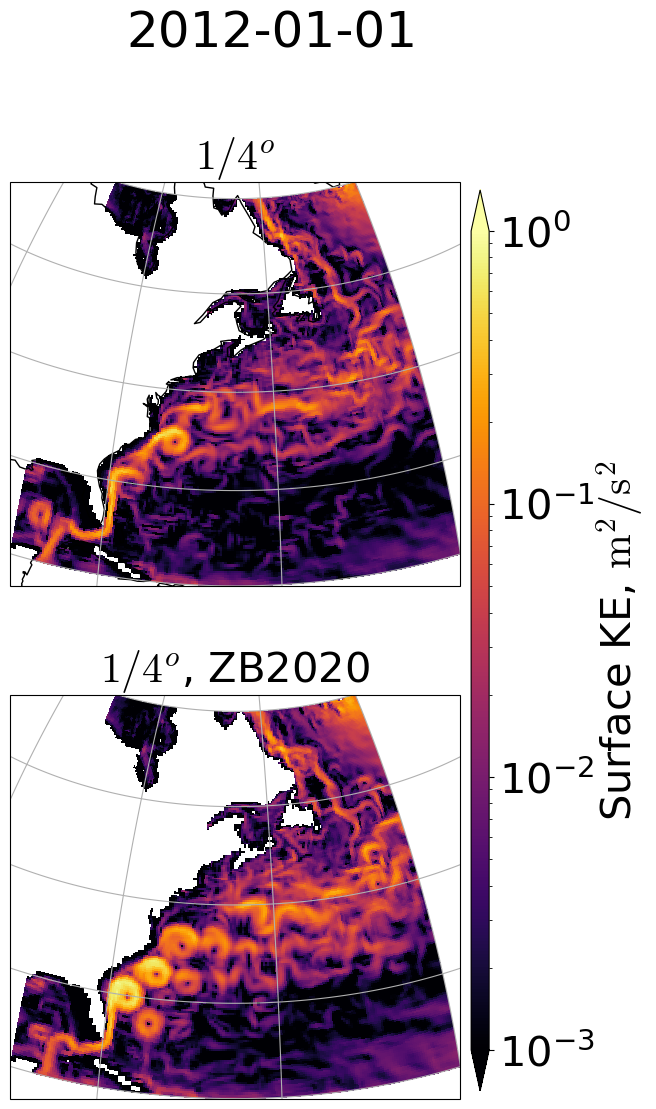

In [ ]:
plot_Atlantic = lambda idx, fig: plot_regions(
    i=idx, lat=slice(20, 60), lon=slice(-90, -40), fig=fig
)
plot_Atlantic(1461, None)
# plot_Atlantic(1826)

Saving the corresponding animation

In [ ]:
%%time
create_gif(
    plot_Atlantic,
    range(1461, 1826, 5),
    filename="./global-ZB2020-Atlantic.gif",
    dpi=200,
    FPS=18,
    loop=0,
)

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not

CPU times: user 10min 8s, sys: 5min 16s, total: 15min 24s
Wall time: 9min 29s


## Plotting the Surface Kinetic Energy in the Pacific region.

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.


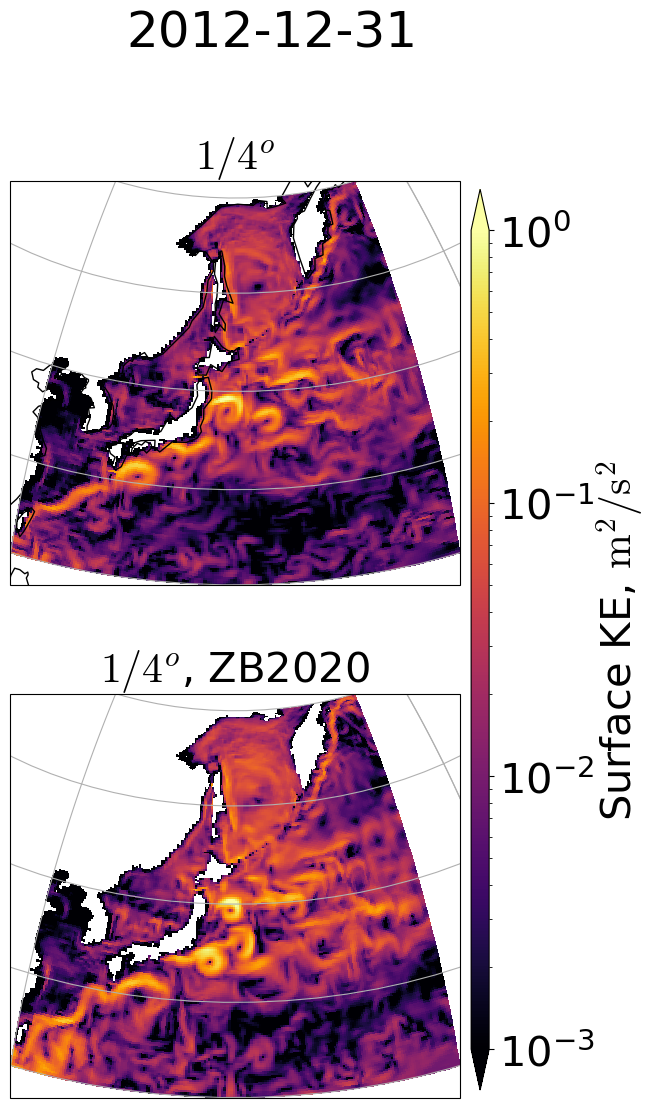

In [ ]:
plot_Pacific = lambda idx, fig: plot_regions(
    i=idx, lat=slice(20, 60), lon=slice(-240, -190), fig=fig
)
plot_Pacific(-1, None)

Saving the corresponding animation

In [ ]:
%%time
create_gif(
    plot_Pacific,
    range(1461, 1826, 5),
    filename="./global-ZB2020-Pacific.gif",
    dpi=200,
    FPS=18,
    loop=0,
)

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not

CPU times: user 9min 55s, sys: 5min 2s, total: 14min 57s
Wall time: 9min 22s


## Plotting the Surface Kinetic Energy in the Aghulas region

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.


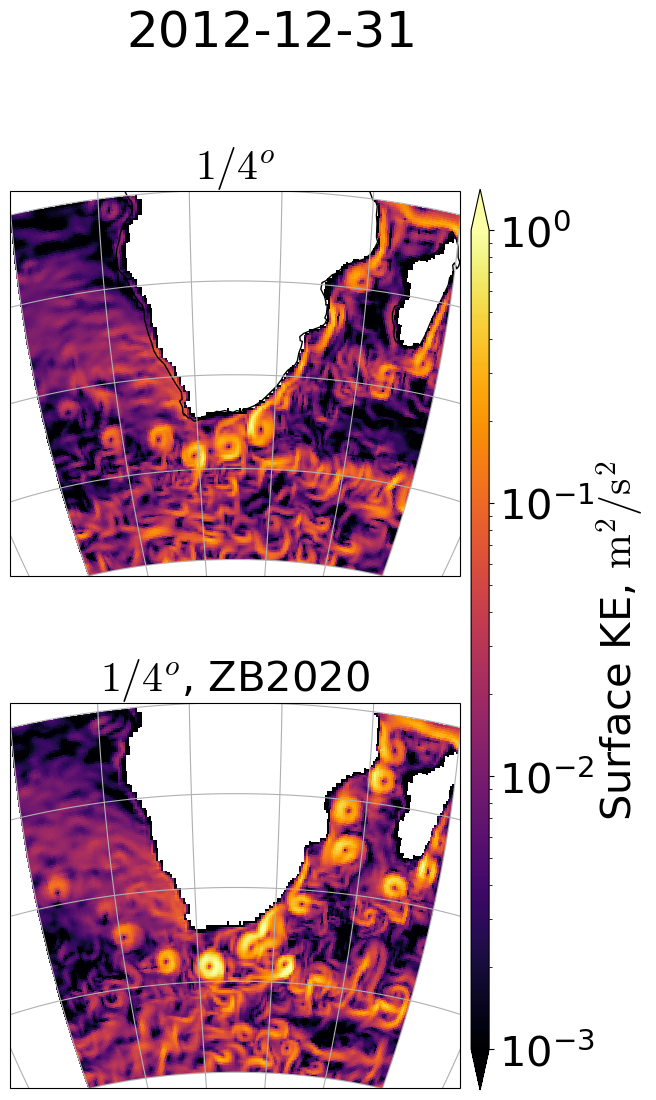

In [ ]:
plot_Aghulas = lambda idx, fig: plot_regions(
    idx=idx, lat=slice(-50, -10), lon=slice(0, 50), fig=fig
)
plot_Aghulas(-1, None)

Saving the corresponding animation

In [ ]:
%%time
create_gif(
    plot_Aghulas,
    range(1461, 1826, 5),
    filename="./global-ZB2020-Aghulas.gif",
    dpi=200,
    FPS=18,
    loop=0,
)

findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not found.
findfont: Font family 'MathJax_Main' not

CPU times: user 9min 53s, sys: 5min 2s, total: 14min 56s
Wall time: 9min 11s
